In [9]:
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
from common import dat

In [10]:
import gi
gi.require_version('Gtk', '3.0')
from graph_tool.all import *

In [11]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
import networks as f

In [13]:
import graph_tool
graph_tool.openmp_set_num_threads(4)

In [32]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=2)

### Select `elaspic` PPI data from the database

In [14]:
sql_query = r"""\
SELECT 
uniprot_domain_pair_id,
domain_contact_id,
model_filename,
uniprot_domain_id_1,
uniprot_domain_id_2,
ud1_uniprot_id,
ud2_uniprot_id,
ud1_cath_id,
ud2_cath_id,
ud1_model_filename,
ud2_model_filename,
s.organism_name
FROM elaspic.d_pair_full_v2f
JOIN uniprot_kb.uniprot_sequence s ON (s.uniprot_id = ud1_uniprot_id)
INTO OUTFILE '/tmp/elaspic_interactome_all.tsv' 
FIELDS TERMINATED BY '\t' OPTIONALLY ENCLOSED BY '"' 
LINES TERMINATED BY '\n';
"""
dat.print_sql(sql_query)

### Load `elaspic` PPI data locally

In [15]:
# Copy exported data to the local folder
#!rsync strokach@192.168.6.19:/tmp/elaspic_interactome_all.tsv .

In [16]:
# Load SQL query results
try:
    elaspic_interactome_all = pd.read_pickle('elaspic_interactome_all.pickle')
except:
    print("Recreating 'elaspic_interactome_all'...")
    names = [
        'uniprot_domain_pair_id',
        'domain_contact_id',
        'model_filename',
        'uniprot_domain_id_1',
        'uniprot_domain_id_2',
        'ud1_uniprot_id',
        'ud2_uniprot_id',
        'ud1_cath_id',
        'ud2_cath_id',
        'ud1_model_filename',
        'ud2_model_filename',
        'organism_name',
    ]
    elaspic_interactome_all = pd.read_csv(
        'elaspic_interactome_all.tsv', 
        sep='\t', na_values=[r'\N'], names=names, low_memory=False,
    )
    elaspic_interactome_all['uniprot_pair'] = (
        elaspic_interactome_all[['ud1_uniprot_id', 'ud2_uniprot_id']]
        .apply(lambda x: '_'.join(sorted(x)), axis=1)
    )
    elaspic_interactome_all.to_pickle('elaspic_interactome_all.pickle')

In [17]:
# See what we get
display(HTML('<h4>elaspic_interactome_all</h4>'))
display(elaspic_interactome_all.head(3))
dat.print2("Number of rows:", elaspic_interactome_all.shape[0])

uniprot_domain_pair_id  domain_contact_id            model_filename  \
0                17627441              88067  A0AVN2_A0AVN2_2y43AB.pdb   
1                17627459             248370  A0AVN2_E9PFC7_1jm7BA.pdb   
2                17627531                NaN                       NaN   

   uniprot_domain_id_1  uniprot_domain_id_2 ud1_uniprot_id ud2_uniprot_id  \
0                20777                20777         A0AVN2         A0AVN2   
1                20777             13689654         A0AVN2         E9PFC7   
2                20777             24434778         A0AVN2         P02795   

  ud1_cath_id ud2_cath_id ud1_model_filename    ud2_model_filename  \
0     1jm7B00     1jm7B00   A0AVN2_1jm7B.pdb      A0AVN2_1jm7B.pdb   
1     1jm7B00     1jm7A00   A0AVN2_1jm7B.pdb  E9PFC7.B99990001.pdb   
2     1jm7B00     4mt2A00   A0AVN2_1jm7B.pdb  P02795.B99990001.pdb   

  organism_name   uniprot_pair  
0  Homo sapiens  A0AVN2_A0AVN2  
1  Homo sapiens  A0AVN2_E9PFC7  
2  Homo sapiens  A0AVN2_P02795

Number of rows:                                             9179216


In [18]:
# Select only human proteins
elaspic_interactome_human = (
    elaspic_interactome_all[
        elaspic_interactome_all['organism_name'] == 'Homo sapiens'
    ]
)

In [19]:
# See what we get
display(HTML('<h4>elaspic_interactome_human</h4>'))
display(elaspic_interactome_human.head(3))
dat.print2("Number of rows:", elaspic_interactome_human.shape[0])

uniprot_domain_pair_id  domain_contact_id            model_filename  \
0                17627441              88067  A0AVN2_A0AVN2_2y43AB.pdb   
1                17627459             248370  A0AVN2_E9PFC7_1jm7BA.pdb   
2                17627531                NaN                       NaN   

   uniprot_domain_id_1  uniprot_domain_id_2 ud1_uniprot_id ud2_uniprot_id  \
0                20777                20777         A0AVN2         A0AVN2   
1                20777             13689654         A0AVN2         E9PFC7   
2                20777             24434778         A0AVN2         P02795   

  ud1_cath_id ud2_cath_id ud1_model_filename    ud2_model_filename  \
0     1jm7B00     1jm7B00   A0AVN2_1jm7B.pdb      A0AVN2_1jm7B.pdb   
1     1jm7B00     1jm7A00   A0AVN2_1jm7B.pdb  E9PFC7.B99990001.pdb   
2     1jm7B00     4mt2A00   A0AVN2_1jm7B.pdb  P02795.B99990001.pdb   

  organism_name   uniprot_pair  
0  Homo sapiens  A0AVN2_A0AVN2  
1  Homo sapiens  A0AVN2_E9PFC7  
2  Homo sapiens  A0AVN2_P02795

Number of rows:                                             9146217


In [20]:
# Add model and mutation aggregate data
# ...these pickles were generated using '/elaspic_tools/interactome.ipynb'
path_to_interactome_data = (
    '/home/kimlab1/strokach/working/elaspic_tools/interactome'
)

interface_models = pd.read_pickle(
    os.path.join(path_to_interactome_data, 'interface_models.pickle')
)
interface_mutations_gp = pd.read_pickle(
    os.path.join(path_to_interactome_data, 'interface_mutations_gp.pickle')
)

elaspic_interactome_human_wmut = (
    elaspic_interactome_human
    .merge(interface_models, how='left', on=['uniprot_domain_pair_id'])
    .merge(interface_mutations_gp, how='left', on=['uniprot_domain_pair_id'])
)

In [21]:
# See what we get
display(HTML('<h4>elaspic_interactome_human_wmut</h4>'))
display(elaspic_interactome_human_wmut.head(3))
dat.print2("Number of rows:", elaspic_interactome_human_wmut.shape[0])

uniprot_domain_pair_id  domain_contact_id            model_filename  \
0                17627441              88067  A0AVN2_A0AVN2_2y43AB.pdb   
1                17627459             248370  A0AVN2_E9PFC7_1jm7BA.pdb   
2                17627531                NaN                       NaN   

   uniprot_domain_id_1  uniprot_domain_id_2 ud1_uniprot_id ud2_uniprot_id  \
0                20777                20777         A0AVN2         A0AVN2   
1                20777             13689654         A0AVN2         E9PFC7   
2                20777             24434778         A0AVN2         P02795   

  ud1_cath_id ud2_cath_id ud1_model_filename          ...           \
0     1jm7B00     1jm7B00   A0AVN2_1jm7B.pdb          ...            
1     1jm7B00     1jm7A00   A0AVN2_1jm7B.pdb          ...            
2     1jm7B00     4mt2A00   A0AVN2_1jm7B.pdb          ...            

  provean_score_mean predictor_ddg_min foldx_ddg_min  provean_score_min  \
0                NaN               NaN           NaN                NaN   
1                NaN               NaN           NaN                NaN   
2                NaN               NaN           NaN                NaN   

   predictor_ddg_max  foldx_ddg_max  provean_score_max  predictor_ddg_abssum  \
0                NaN            NaN                NaN                   NaN   
1                NaN            NaN                NaN                   NaN   
2                NaN            NaN                NaN                   NaN   

   foldx_ddg_abssum  provean_score_abssum  
0               NaN                   NaN  
1               NaN                   NaN  
2               NaN                   NaN  

[3 rows x 32 columns]

Number of rows:                                             9146217


In [22]:
# Exclude splice variants
elaspic_interactome_human_novarsplice = (
    elaspic_interactome_human_wmut[
        ~elaspic_interactome_human_wmut['uniprot_pair'].str.contains('-')
    ]
)

In [23]:
# See what we get
display(HTML('<h4>elaspic_interactome_human_novarsplice</h4>'))
display(elaspic_interactome_human_novarsplice.head(3))
dat.print2("Number of rows:", elaspic_interactome_human_novarsplice.shape[0])

uniprot_domain_pair_id  domain_contact_id            model_filename  \
0                17627441              88067  A0AVN2_A0AVN2_2y43AB.pdb   
1                17627459             248370  A0AVN2_E9PFC7_1jm7BA.pdb   
2                17627531                NaN                       NaN   

   uniprot_domain_id_1  uniprot_domain_id_2 ud1_uniprot_id ud2_uniprot_id  \
0                20777                20777         A0AVN2         A0AVN2   
1                20777             13689654         A0AVN2         E9PFC7   
2                20777             24434778         A0AVN2         P02795   

  ud1_cath_id ud2_cath_id ud1_model_filename          ...           \
0     1jm7B00     1jm7B00   A0AVN2_1jm7B.pdb          ...            
1     1jm7B00     1jm7A00   A0AVN2_1jm7B.pdb          ...            
2     1jm7B00     4mt2A00   A0AVN2_1jm7B.pdb          ...            

  provean_score_mean predictor_ddg_min foldx_ddg_min  provean_score_min  \
0                NaN               NaN           NaN                NaN   
1                NaN               NaN           NaN                NaN   
2                NaN               NaN           NaN                NaN   

   predictor_ddg_max  foldx_ddg_max  provean_score_max  predictor_ddg_abssum  \
0                NaN            NaN                NaN                   NaN   
1                NaN            NaN                NaN                   NaN   
2                NaN            NaN                NaN                   NaN   

   foldx_ddg_abssum  provean_score_abssum  
0               NaN                   NaN  
1               NaN                   NaN  
2               NaN                   NaN  

[3 rows x 32 columns]

Number of rows:                                             1301137


In [24]:
# Create dataframe subsets that only include entries with models
elaspic_interactome_human_wmut_wmodel = (
    elaspic_interactome_human_wmut[
        elaspic_interactome_human_wmut['model_filename'].notnull()
    ]
)

elaspic_interactome_human_novarsplice_wmodel = (
    elaspic_interactome_human_novarsplice[
        elaspic_interactome_human_novarsplice['model_filename'].notnull()
    ]
    
)

In [25]:
# Get vertex properties
elaspic_proteome_human_wmut = (
    pd.concat(
        [
            elaspic_interactome_human_wmut
            [['ud1_uniprot_id', 'ud1_cath_id', 'ud1_model_filename']]
            .rename(columns={
                        'ud1_uniprot_id': 'uniprot_id',
                        'ud1_cath_id': 'cath_id',
                        'ud1_model_filename': 'model_filename',
                    }),
            elaspic_interactome_human_wmut
            [['ud2_uniprot_id', 'ud2_cath_id', 'ud2_model_filename']]
            .rename(columns={
                        'ud2_uniprot_id': 'uniprot_id',
                        'ud2_cath_id': 'cath_id',
                        'ud2_model_filename': 'model_filename',
                    }),
        ], 
        ignore_index=True
    )
)
uniprot_vertex_properties = (
    elaspic_proteome_human_wmut
    .groupby('uniprot_id')
    .agg(lambda x: x.notnull().any())
)

f.print_stats(uniprot_vertex_properties, 'uniprot_vertex_properties')

cath_id model_filename
uniprot_id                       
A0A5B4        True           True
A0A5B9        True           True
A0AUY0        True           True

Number of rows:                     32345


### Construct dataframes of protein-protein interactions

In [ ]:
###raise Exception("Don't do this again unless you have to!")

# Make the graphs and calculate the graph features
###ei_all, u2k_all, k2u_all = (
###    f.format_df(elaspic_interactome_human_wmut)
###)
#up_A_all = f.method_A(ei_all)
###up_B_all = f.method_B(ei_all)
#assert len(up_A_all) == len(up_B_all)
#f.print_stats(up_A_all, 'up_A_all')
###f.print_stats(up_B_all, 'up_B_all')
###g_B_all = f.create_graph(up_B_all, k2u_all, uniprot_vertex_properties)
###g_B_all.save('g_B_all.gt')

###ei_wmodel, u2k_wmodel, k2u_wmodel = (
###    f.format_df(elaspic_interactome_human_wmut_wmodel)
###)
#up_A_wmodel = f.method_A(ei_wmodel)
###up_B_wmodel = f.method_B(ei_wmodel)
#assert len(up_A_wmodel) == len(up_B_wmodel)
#f.print_stats(up_A_wmodel, 'up_A_wmodel')
###f.print_stats(up_B_wmodel, 'up_B_wmodel')
###g_B_wmodel = f.create_graph(up_B_all, k2u_all, uniprot_vertex_properties)
###g_B_wmodel.save('g_B_wmodel.gt')

ei_novarsplice, u2k_novarsplice, k2u_novarsplice = (
    f.format_df(elaspic_interactome_human_novarsplice)
)
#up_A_novarsplice = f.method_A(ei_novarsplice)
up_B_novarsplice = f.method_B(ei_novarsplice)
#assert len(up_A_novarsplice) == len(up_B_novarsplice)
#f.print_stats(up_A_novarsplice, 'up_A_novarsplice')
f.print_stats(up_B_novarsplice, 'up_B_novarsplice')
g_B_novarsplice = f.create_graph(up_B_novarsplice, k2u_novarsplice, uniprot_vertex_properties)
g_B_novarsplice.save('g_B_novarsplice.gt')

####ei_novarsplice_wmodel, u2k_novarsplice_wmodel, k2u_novarsplice_wmodel = (
####    f.format_df(elaspic_interactome_human_novarsplice_wmodel)
####)
#up_A_novarsplice_wmodel = f.method_A(ei_novarsplice_wmodel)
###up_B_novarsplice_wmodel = f.method_B(ei_novarsplice_wmodel)
#assert len(up_A_novarsplice_wmodel) == len(up_B_novarsplice_wmodel)
####f.print_stats(up_A_novarsplice_wmodel, 'up_A_novarsplice_wmodel')
###f.print_stats(up_B_novarsplice_wmodel, 'up_B_novarsplice_wmodel')
###g_B_novarsplice_wmodel = f.create_graph(up_B_all, k2u_all, uniprot_vertex_properties)
###g_B_novarsplice_wmodel.save('g_B_novarsplice_wmodel.gt')

Done...


uniprot_domain_pair_id  domain_contact_id  \
uniprot_id_1 uniprot_id_2                                              
Q16548       Q96LC9                       3464024             231140   
O43521       Q16548                       3463982              79001   
P07199       P07199                       3625462             305397   

                                     model_filename  uniprot_domain_id_1  \
uniprot_id_1 uniprot_id_2                                                  
Q16548       Q96LC9        Q16548_Q96LC9_2vogAB.pdb             31875586   
O43521       Q16548        Q16548_O43521_2vm6AB.pdb             31875586   
P07199       P07199        P07199_P07199_1ufiCD.pdb             79759255   

                           uniprot_domain_id_2 ud1_uniprot_id ud2_uniprot_id  \
uniprot_id_1 uniprot_id_2                                                      
Q16548       Q96LC9                   95761251         Q16548         Q96LC9   
O43521       Q16548                   93972860         Q16548         O43521   
P07199       P07199                   79759255         P07199         P07199   

                          ud1_cath_id ud2_cath_id ud1_model_filename  \
uniprot_id_1 uniprot_id_2                                              
Q16548       Q96LC9           3mqpA00     2vogB00   Q16548_3mqpA.pdb   
O43521       Q16548           3mqpA00     4b4sB00   Q16548_3mqpA.pdb   
P07199       P07199           1ufiA00     1ufiA00   P07199_1ufiA.pdb   

                               ...       foldx_ddg_min provean_score_min  \
uniprot_id_1 uniprot_id_2      ...                                         
Q16548       Q96LC9            ...              0.2225            -4.391   
O43521       Q16548            ...             -0.1079            -3.936   
P07199       P07199            ...             -0.0780            -1.342   

                          predictor_ddg_max  foldx_ddg_max  provean_score_max  \
uniprot_id_1 uniprot_id_2                                                       
Q16548       Q96LC9                2.524660         1.4321             -3.024   
O43521       Q16548                0.932009         0.6988             -2.144   
P07199       P07199                1.330260         0.7027              0.428   

                           predictor_ddg_abssum  foldx_ddg_abssum  \
uniprot_id_1 uniprot_id_2                                           
Q16548       Q96LC9                    5.099619            2.0290   
O43521       Q16548                    1.554300            0.8539   
P07199       P07199                    2.208325            1.2096   

                           provean_score_abssum  uniprot_key_1  uniprot_key_2  
uniprot_id_1 uniprot_id_2                                                      
Q16548       Q96LC9                      11.135           2459          11809  
O43521       Q16548                       8.879           2758           2459  
P07199       P07199                       2.659            105            105  

[3 rows x 34 columns]

# Load the graphs that we just created

In [ ]:
#ei_all, u2k_all, k2u_all = (
#    f.format_df(elaspic_interactome_human_wmut)
#)
#g_B_all = load_graph('g_B_all.gt')

#ei_wmodel, u2k_wmodel, k2u_wmodel = (
#    f.format_df(elaspic_interactome_human_wmut_wmodel)
#)
#g_B_wmodel = load_graph('g_B_wmodel.gt')

ei_novarsplice, u2k_novarsplice, k2u_novarsplice = (
    f.format_df(elaspic_interactome_human_novarsplice)
)
g_B_novarsplice = load_graph('g_B_novarsplice.gt')
#
#ei_novarsplice_wmodel, u2k_novarsplice_wmodel, k2u_novarsplice_wmodel = (
#    f.format_df(elaspic_interactome_human_novarsplice_wmodel)
#)
#g_B_novarsplice_wmodel = load_graph('g_B_novarsplice_wmodel.gt')

In [ ]:
plt.hist(g_B_novarsplice.ep['betweenness'].a, range=(0,0.00001))
plt.xlabel("Betweenness centrality of interfaces")
plt.ylabel("Number of interfaces")
plt.vlines(0.000004, 0, 350000, colors='r', line)

In [ ]:
ei_novarsplice.head()

In [ ]:
data = np.zeros((len(g_B_novarsplice.ep['betweenness'].a), 3))

In [ ]:
for i, ((a, b), betweenness) in enumerate(zip(g_B_novarsplice.edges(), g_B_novarsplice.ep['betweenness'].a)):
    data[i,] = (int(a), int(b), betweenness)


In [ ]:
data_df = pd.DataFrame(data, columns=['uniprot_key_1', 'uniprot_key_2', 'betweenness'])




In [ ]:
data_df.to_pickle('data_df.pickle')

In [ ]:
data_df.head()

In [ ]:
ei_novarsplice.head()

In [ ]:
ei_novarsplice_wbetweenness = ei_novarsplice.merge(data_df)

In [ ]:
len(ei_novarsplice.drop_duplicates(['uniprot_key_1', 'uniprot_key_2']))

In [ ]:
len(data_df.drop_duplicates(['uniprot_key_1', 'uniprot_key_2']))

In [120]:
len(ei_novarsplice_wbetweenness.drop_duplicates(['uniprot_key_1', 'uniprot_key_2']))

1299

ValueError: x has only one data point. bins or range kwarg must be given

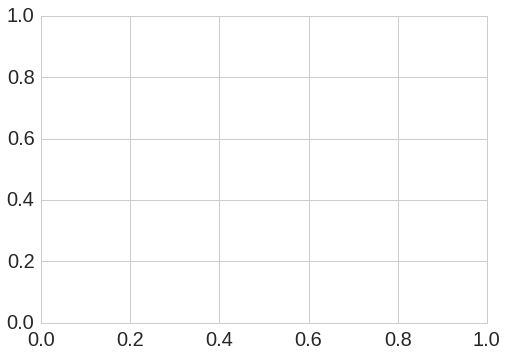

In [49]:
plt.hist(g_B_novarsplice_wmodel.ep['betweenness'])

In [36]:
g_B_novarsplice_wmodel.ep.keys()

dict_keys(['have_model', 'betweenness', 'have_template'])

In [29]:
V = shortest_distance(g)

NameError: name 'g' is not defined

In [ ]:
%%time
mydict['v_betweenness'], mydict['e_betweenness'] = betweenness(g)

In [ ]:
%%time
mydict['local_clustering'] = local_clustering(g)

In [ ]:
%%time
mydict['extended_clustering'] = extended_clustering(g, max_depth=5)

In [ ]:
%%time
mydict['pagerank'] = pagerank(g)

In [ ]:
%%time
mydict['closeness'] = closeness(g)

In [ ]:
%%time
mydict['V'] = shortest_distance(g)

In [ ]:
%%time
mydict['trust_transitivity'] = trust_transitivity(g)

In [ ]:
mydict = dict()

# clustering
mydict['local_clustering'] = local_clustering(g)
mydict['extended_clustering'] = extended_clustering(g)

# centrality measures
mydict['pagerank'] = pagerank(g)
mydict['closeness'] = closeness(g)
mydict['katz'] = katz(g)
mydict['eigentrust'] = eigentrust(g)
mydict['trust_transitivity'] = trust_transitivity(g)

# betweenness
mydict['v_betweenness'], mydict['e_betweenness'] = betweenness(g)

#
mydict['V'] = shortest_distance(g)

In [ ]:
up_B_all.dtypes

In [ ]:
import importlib
importlib.reload(f)

In [ ]:
f.method_B

In [ ]:
import inspect
print(inspect.getsource(f.method_B))

In [ ]:
uniprot_pairs.head()

In [ ]:
uniprot_pairs_all, uniprot2key_all, key2uniprot_all = format_df(uniprot_pairs)
uniprot_pairs_all = uniprot_pairs_all.set_index(['uniprot_id_1', 'uniprot_id_2'])
print_stats(uniprot_pairs_all, 'uniprot_pairs')

In [ ]:
uniprot_pairs_wmodel = uniprot_pairs[uniprot_pairs['model_filename']]
uniprot_pairs_wmodel, uniprot2key_wmodel, key2uniprot_wmodel = format_df(uniprot_pairs)
uniprot_pairs_wmodel = uniprot_pairs_wmodel.set_index(['uniprot_id_1', 'uniprot_id_2'])
print_stats(uniprot_pairs_wmodel, 'uniprot_pairs')

In [ ]:
# Edge properties

In [ ]:
max_flow_1 = edmonds_karp_max_flow(g)

In [ ]:
max_flow_2 = push_relabel_max_flow(g)

In [ ]:
max_flow_3 = boykov_kolmogorov_max_flow(g)